In [1]:
import glob
import cv2
import os.path as path
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from common import *

%matplotlib inline

In [2]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    return heatmap
    
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap


# Car detection in images

In [3]:
from sklearn.externals import joblib 

data = joblib.load('./output_model/model.pkl')

classifier = data['classifier']
feature_params = data['feature_params']
feature_params

{'cell_per_block': 2,
 'color_space': 'YUV',
 'hist_bins': 32,
 'hog_channel': 'ALL',
 'orient': 11,
 'pix_per_cell': 8,
 'spatial_size': 32}

In [4]:
class CarFinder:
    window_size = 64
    cells_per_step = 2
    
    def __init__(self, classifier, feature_params):
        self.classifier = classifier
        self.orient = feature_params['orient']
        self.spatial_size = feature_params['spatial_size']
        self.hist_bins = feature_params['hist_bins']
        self.pix_per_cell = feature_params['pix_per_cell']
        self.color_space = feature_params['color_space']
        self.cell_per_block = feature_params['cell_per_block']
        
    def hog_features(self, *channels):
        return [get_hog_features(channel, self.orient, self.pix_per_cell, self.cell_per_block,feature_vec=False)
                   for channel in channels]
    
    def transform_color_space(self, image):
        return convert_colorspace(image, self.color_space)
    
    def scale_image(self, image, scale):
        if scale != 1:
            imshape = image.shape
            image = cv2.resize(image, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
            
        return image
    
    def iterate(self, x_steps, y_steps):
        for xb in range(x_steps):
            for yb in range(y_steps):
                ypos = yb * self.cells_per_step
                xpos = xb * self.cells_per_step
                yield (xpos, ypos)
        
    
    def __call__(self, img, ystart, ystop, scale):
        ctrans_tosearch = self.transform_color_space(img[ystart:ystop,:,:])
        ctrans_tosearch = self.scale_image(ctrans_tosearch, scale)

        # Define blocks and steps as above
        nxblocks = (ctrans_tosearch.shape[1] // self.pix_per_cell) - self.cell_per_block + 1
        nyblocks = (ctrans_tosearch.shape[0] // self.pix_per_cell) - self.cell_per_block + 1 

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        nblocks_per_window = (self.window_size // self.pix_per_cell) - self.cell_per_block + 1
        nxsteps = (nxblocks - nblocks_per_window) // self.cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // self.cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1, hog2, hog3 = self.hog_features(ctrans_tosearch[:,:,0], 
                                             ctrans_tosearch[:,:,1], 
                                             ctrans_tosearch[:,:,2])

        rectangles = []
        for xpos, ypos in self.iterate(nxsteps, nysteps):
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * self.pix_per_cell
            ytop = ypos * self.pix_per_cell

            features = []

            # Extract the image patch
            subimg = ctrans_tosearch[ytop:ytop+self.window_size, xleft:xleft+self.window_size]
            if self.spatial_size > 0: 
                spatial_features = bin_spatial(subimg, size=(self.spatial_size, self.spatial_size))
                features.append(spatial_features)

            if self.hist_bins > 0:
                color_features = color_hist(subimg, nbins=self.hist_bins)
                features.append(color_features)

            features.append(hog_features)

            test_features = np.hstack(features).reshape(1, -1)    
            test_prediction = self.classifier.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(self.window_size*scale)
                rect = [(xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)]
                rectangles.append(rect)

        return rectangles
    
finder = CarFinder(classifier, feature_params)


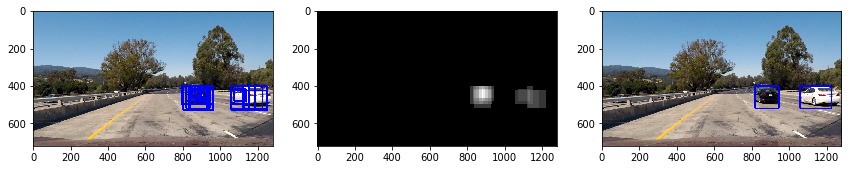

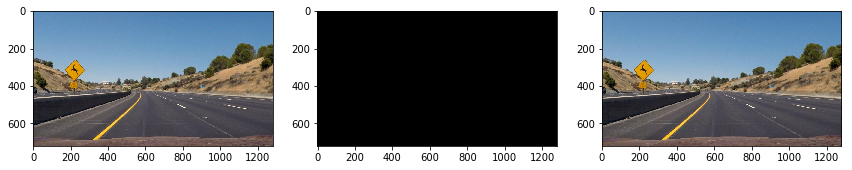

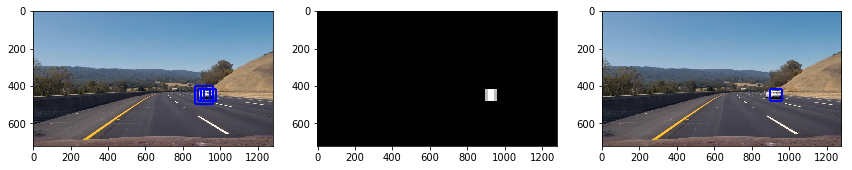

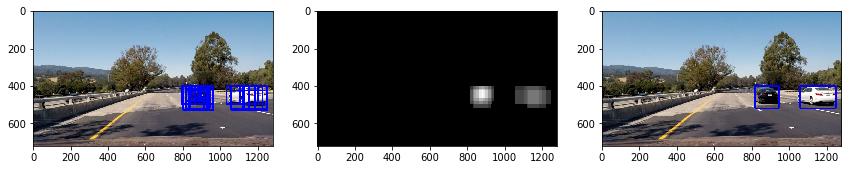

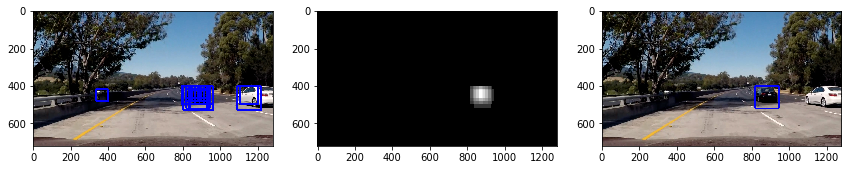

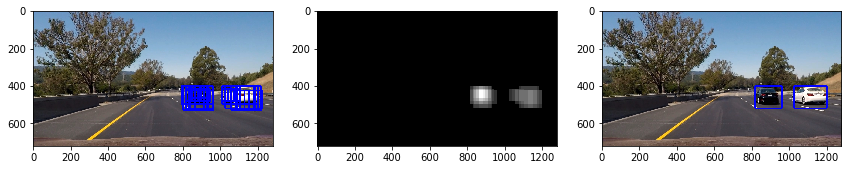

In [5]:
from scipy.ndimage.measurements import label
from collections import deque

class AccumulativeCarDetector:
    buffer_size = 20
    
    def __init__(self, car_finder, threshold):
        self.threshold = threshold
        self.car_finder = car_finder
        self.frame_buffer = deque(maxlen=self.buffer_size)
        
    def __call__(self, frame):
        self.hot_rects = self.detect_hot_rects(frame)
        self.frame_buffer.append(self.hot_rects)
        return self.draw_label_boxes(frame)
    
    def detect_hot_rects(self, image):
        hot_rects = self.car_finder(image, 400, 500, 1)
        hot_rects += self.car_finder(image, 400, 600, 1.5)
        hot_rects += self.car_finder(image, 400, 650, 2)
        return hot_rects
    
    def draw_label_boxes(self, frame):
        self.heatmap = np.zeros(frame.shape[0:2])
        for rects in self.frame_buffer:
            add_heat(self.heatmap, rects)
            
        apply_threshold(self.heatmap, self.threshold)
        labels = label(self.heatmap)
        return draw_labeled_bboxes(frame, labels)

def create_detector(classifier, feature_params, detection_threshold=2):
    car_finder = CarFinder(classifier, feature_params)
    return AccumulativeCarDetector(car_finder, detection_threshold)
    
imfiles = glob.glob('./test_images/*.jpg')    
for i, imfile in enumerate(imfiles):
    image = read_image(imfile)
    detector = create_detector(classifier, feature_params, 2)
    labels = detector(image)
    
    fig, ax = plt.subplots(1, 3, figsize=(12, 5))    
    ax[0].imshow(draw_boxes(image, detector.hot_rects))
    ax[1].imshow(detector.heatmap, 'gray')
    ax[2].imshow(labels)
    fig.tight_layout()    
    fig.savefig('./output_images/car_detection_' + str(i) + '.png')


# Video processing pipeline

In [6]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def display_video(video_file):
    return HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_file))

def make_output_path(filename):
    basename = path.basename(filename)
    return path.join('./output_images', basename)

def process_video(filename, processor):
    clip = VideoFileClip(filename)
    processed = clip.fl_image(processor)
    
    output_file = make_output_path(filename)
    processed.write_videofile(output_file, audio=False)
    return output_file

In [7]:
output = process_video('./project_video.mp4', create_detector(classifier, feature_params, 30))

[MoviePy] >>>> Building video ./output_images/project_video.mp4
[MoviePy] Writing video ./output_images/project_video.mp4


100%|█████████▉| 1260/1261 [10:00<00:00,  2.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_video.mp4 



In [8]:
display_video(output)